In [3]:
import DataFrames: subset
include("Algorithm/utilities.jl")

refreshFile (generic function with 1 method)

In [4]:
using JLD

In [5]:
co = load("Data/communities.jld")

Dict{String,Any} with 2 entries:
  "normCommunities" => [1.0 -0.0461484 … 0.466352 0.367157; -0.0461484 1.0 … -0…
  "communities"     => [0.0161051 -0.000958807 … 0.0142233 0.0108558; -0.000958…

In [6]:
prob = problem(sqrt(co["normCommunities"]), co["normCommunities"])

problem([0.4790992488364379 -0.017550988861969825 … 0.12715754213980085 0.06451162013328997; -0.017550988861969825 0.5575866342001611 … -0.03136297161679047 -0.00551720369323595; … ; 0.12715754213980085 -0.03136297161679047 … 0.9032994126421733 0.08129473223807368; 0.06451162013328997 -0.00551720369323595 … 0.08129473223807368 0.7271195468258385], [1.0 -0.04614840723762598 … 0.4663522938683093 0.3671573782735259; -0.04614840723762598 1.0 … -0.09436752238327721 -0.03492259533593246; … ; 0.4663522938683093 -0.09436752238327721 … 1.0 0.34862725802493033; 0.3671573782735259 -0.03492259533593246 … 0.34862725802493033 1.0])

In [14]:
using LinearAlgebra, Printf, Arpack
function branchAndBound(prob, #problem object
		K; # target sparsity
		outputFlag = 3, # 1, 2, or 3 depending on level of detail sought in output
		timeCap = 3600, #maximum time in seconds
		warmStart = zeros(1), #warm start vector

		maxDepth = 1000, #maximum number of active nodes in the tree
		localSearchSteps = 2, # number of steps to take to find good feasible solutions at each node
		ksegmentsTrigger = 0, # use alternative branching when the number of indices left to set falls below this number
		dimSelectSteps = 10, # number of steps to take in choosing the dimension to branch on
		branchDimSelectMethod = 0,
		UOE=5000, # buffer to add when resizing arrays containing nodes and bounds
		gap = .000001, # optimality gap for the algorithm
		eigGap = .00001, # convergence criterion for determining eigenavlues by power method
		eigCycles = 500, # max number of iterations of the power method
		valtobeat = 0) # if non-zero, the algorithm will terminate once it has a solution with objective value larger than this

	# computes the vector b that maximizes b'Qb
	# subject to the support of b being <= abs(y)
	# terminates convergence early once the eigenvalue crosses refineCap (if not 0)
	# refineCap is used when generating multiple upper bounds for a subproblem
	# since we want to take the least upper bound, we terminate this function once any
	# more refinement would no longer impact the least upper bound
	function bbMyeigmax(y, refineCap)
		yKeep = .!(y.==0)
		thism=0
		if highDim
			thisA = copy(A[:, yKeep])
			thism, ~ = size(thisA)
			Q = thisA*thisA'/(thism-1)
			b = startingEig[yKeep]
			b = thisA*(b / LinearAlgebra.norm(b))
			normb = 0
			newnorm = LinearAlgebra.norm(b)
		else
			Q = copy(Sigma[yKeep,yKeep])
			beta0 = startingEig[yKeep]
			normb = LinearAlgebra.norm(beta0)
			b = Q*beta0
			newnorm = LinearAlgebra.norm(b)
		end

		cycles = 0
		while abs(normb - newnorm) > eigGap*normb && cycles < eigCycles
			normb = newnorm
			b = Q*(b / normb)
			newnorm = LinearAlgebra.norm(b)
			if refineCap>0
				if newnorm > refineCap
					return refineCap, copy(b/normb)
				end
			end
			cycles = cycles + 1
		end

		if highDim
			b = thisA'*b
			b = thisA'*(thisA*b/LinearAlgebra.norm(b))/(thism-1)
			normb = LinearAlgebra.norm(b)
		end

		b = b/normb
		expandedb = zeros(length(y))
		expandedb[yKeep]=b

		return normb, expandedb
	end

	# Returns the upper and lower bounds for the problem at node y
	# oldub is the upper bound of the parent node, which provides a maximum value
	# that the upper bound at y could have.  Feeding oldub into eigen_bound helps
	# reduce time spent in that function
	function return_bounds(y, oldub)
		if sum(max.(y,0)) == K
			eig_power_elapsed += @elapsed val, ~ = bbMyeigmax(max.(y,0), 0)
			return [val val]
		elseif sum(abs.(y)) == K
			eig_power_elapsed += @elapsed val, ~ = bbMyeigmax(abs.(y), 0)
			return [val val]
		else
			eb = eigen_bound(y, oldub)
			eig_power_elapsed += @elapsed true_upper, ~ = bbMyeigmax(y, eb)
			lower_val = YuanSubset(y)[1]
			return [lower_val true_upper]
		end
	end

	# Computes two upper bounds for the problem at node y
	# The first is based on gershgorin circle theorem
	# The second is based on the trace
	# The function returns the lesser of the two bounds
	# oldub (the upper bound from the parent node) provides a maximum value on
	# the upper bound at y.  It is used here to terminate the gershgorin calculation early
	# if the gershgorin bound is higher than oldub
	function eigen_bound(y, oldub)
		ypositive = (y.==1)
		numpositive = sum(ypositive)
		stillneed = K-numpositive

		#Uses maximum absolute column sums to provide an upper bound on eigenvalues
		#Inspired by gershgorin circle theorem
		#Hard to scale well
		stillneed = K-numpositive
		startingsums = sum(absSigma[:, ypositive],dims=2)

		eb1=0
		cutoff = oldub*(1-1e-6)

		for i=1:length(y) # scanning over all columns
			if y[i]==-1 || y[i]==1 # which columns to consider
			    newsum = startingsums[i] # must include these rows
			    added = 0
			    if y[i]==-1 
			    	# if we choose column i, we must choose row i
			    	newsum = newsum + absSigma[i,i]
			    	added = 1
			    end
			    j=1
			    while added < stillneed
			        candidateIndex = permMat[i,j]
			        if y[candidateIndex]==-1 && candidateIndex != i
			            newsum = newsum + absSigma[i,candidateIndex]
			            added = added + 1
			        end
			        j=j+1
			    end
			    if newsum>eb1
			        eb1=newsum
			        if newsum>cutoff
			    		break
			    	end
			    end
			end
		end

		#based on how the trace is a bound on the eigenvalues since they're all positive
		startingsums = sum(diagSigma[ypositive])
		indicesLeft = sortedOrder[y.==-1]
		eb2 = startingsums+sum(selectsorted(diagSigma[indicesLeft],stillneed))

		return min(eb1,eb2)
	end

	function both_upper_bounds(y)
		ypositive = (y.==1)
		numpositive = sum(ypositive)
		stillneed = K-numpositive

		#Uses maximum absolute column sums to provide an upper bound on eigenvalues
		#Inspired by gershgorin circle theorem
		#Hard to scale well
		stillneed = K-numpositive
		startingsums = sum(absSigma[:, ypositive],dims=2)

		eb1=0

		for i=1:length(y) # scanning over all columns
			if y[i]==-1 || y[i]==1 # which columns to consider
			    newsum = startingsums[i] # must include these rows
			    added = 0
			    if y[i]==-1 
			    	# if we choose column i, we must choose row i
			    	newsum = newsum + absSigma[i,i]
			    	added = 1
			    end
			    j=1
			    while added < stillneed
			        candidateIndex = permMat[i,j]
			        if y[candidateIndex]==-1 && candidateIndex != i
			            newsum = newsum + absSigma[i,candidateIndex]
			            added = added + 1
			        end
			        j=j+1
			    end
			    if newsum>eb1
			        eb1=newsum
			    end
			end
		end

		#based on how the trace is a bound on the eigenvalues since they're all positive
		startingsums = sum(diagSigma[ypositive])
		indicesLeft = sortedOrder[y.==-1]
		eb2 = startingsums+sum(selectsorted(diagSigma[indicesLeft],stillneed))

		return [eb1; eb2]
	end

	# Returns true if y represents a terminal node (only one k-sparse support is feasible)
	# Returns false otherwise
	function isTerminal(y)
		if sum(max.(y,0)) >= K return true end
		if sum(abs.(y)) <= K return true end
		return false
	end

	# Selects the dimension to branch on from node y
	# Finds the dimension among those with y_i==-1 that corresponds to the largest
	# loading of the "eigenvector" b that maximizes b'Qb subject to the support of b
	# being where y_i == -1.
	function branchDimSelect(y)
		#"dumb", "smart", "random", "semirandom"
		negindices = findall(s -> s == -1, y)

		if branchDimSelectMethod == 0  # adaptive

			# dimSelectLookup is a dictionary
			# It starts empty, but once dim is determined for some set of negindices
			# it is saved in dimSelectLookup, to prevent having to recompute it later
			dim = get(dimSelectLookup, negindices, 0)
			if dim > 0
				return dim
			else
				Q = Sigma[negindices,negindices]
				b = startingEig[negindices]
				for i = 1:dimSelectSteps
					b = Q*(b / LinearAlgebra.norm(b))
				end
				dim = negindices[findmax(abs.(b))[2]]
				dimSelectLookup[negindices] = dim
			end
		elseif branchDimSelectMethod == 1 # random
			dim = rand(negindices)
		elseif branchDimSelectMethod == 2 # sort by Q_ii
			dim = intersect(sortedOrder, negindices)[1]
		else # sort by loading on first eigenvector
			dim = intersect(firsteigOrder, negindices)[1]
		end
		return dim
	end

	# Applies the Yuan and Zhang first order heuristic for localSearchSteps steps
	# In order to generate a lower bound for the problem at y
	function YuanSubset(y)
		beta = Hk(startingEig, K, y)

			for i = 1:localSearchSteps
				beta = Hk(sparseTimes(Sigma,beta), K, y)
			end
			bestObj = (transpose(beta)*sparseTimes(Sigma,beta))[1]

		return bestObj, beta
	end

	# Selects which node to branch on
	# Depends primarily on the parameter maxDepth and the size of the tree
	# If the size of the tree is small, will select the node with the highest upper bound
	# If the tree is large, it wil pick the most recently created node (depth first search)
	function select_node()
		nn = sum(.!death[1:num_nodes])
		if nn == 0
			return 0
		end
		if nn < maxDepth
			return max_ub_select()
		else
			return depth_select()
		end
	end

	# Function to select the node with the highest upper bound
	# This will necessarily not be terminal as long as the algorithm hasn't converged
	function max_ub_select()
		fm = findmax(upper_bounds)
		if fm[1] > 0
			return fm[2]
		else
			return 0
		end
	end

	# Function to select the most recently created node that is not terminal
	function depth_select()
		selected_node = num_nodes
		while (isTerminal(nodes[:, selected_node]) | death[selected_node])
			selected_node = selected_node-1
			if selected_node == 0
				return 0
			end
		end
		return selected_node
	end

	# Beginning the algorithm
	start = time();

	Sigma = prob.Sigma
	absSigma = abs.(Sigma)
	diagSigma = LinearAlgebra.diag(Sigma)
	sortedOrder = sortperm(-diagSigma) #order from largest to smallest

	permMat = round.(Int64,zeros(size(absSigma)))
	for i=1:size(permMat)[2]
	    permMat[i,:]=sortperm(vec(absSigma[i,:]),rev=true)
	end

	dimSelectLookup = Dict()

	A = prob.data
	m, n = size(A)

	# detects if high dimenisonal problem, in which case
	# methods should use A'A not Sigma for eigenvalue computations
	highDim = false
	if m < n/2
		highDim = true
	end


	# Uses the Yuan algorithm to generate a warm start if none was provided
	if length(warmStart)==1
		~, warmStart = subset(prob, K, timeLimit = max(20,timeCap/100))
	end



	#initializing variables
	nodes = zeros(n, UOE)
    createdNodes = zeros(n, 0)
	boundsData = zeros(3, 0)
	nodes[:,1] = round.(Integer,-1*ones(n,1))
	upper_bounds = zeros(UOE)

	eigGapSave = eigGap
	eigGap = .000001
	if highDim
		upper_bounds[1], startingEig = myeigmax(A, ones(n), ones(n), true, 0)
	else
		upper_bounds[1], startingEig = myeigmax(Sigma, ones(n), ones(n), false, 0)
	end

	firsteigOrder = sortperm(-abs.(startingEig))


	eigGap = eigGapSave
	upper = maximum(upper_bounds)
	lower = (transpose(warmStart)*Sigma*warmStart)[1]
	death = falses(UOE)
	num_nodes = 1
	bestBound = 0
	BestBoundtime = time()

	# if K=n problem is trivial
	if K == n
		lower = upper
	end

	explored = 0
	lower_revised = 0
	best_node = (warmStart.!=0)*1

	#Initializes output
	# println(" Nodes,   Left,  Objective,  Incumbent,       Gap(%),   Runtime(s)")
	toPrint=[Printf.@sprintf("%6d, %6d, %10f, %10f, %10.3f %%, %10.3f s \n", num_nodes, explored, upper, lower, (upper-lower)/(1e-10+upper)*100, time()-start)]
	printtime = time()
        eig_elapsed = 0.
        eig_power_elapsed = 0.

	while (upper - lower)/upper > gap  && time()-start < timeCap
		explored = explored + 1

		# Occasionally print updates and risize arrays
		if lower_revised == 1 || size(nodes)[2]-num_nodes < K+5 || explored < 100
			nodesToKeep = .!(upper_bounds.< lower) .& .!death
			nodesToKeep = findall(s->s,nodesToKeep)
			nodesToKeep = nodesToKeep[nodesToKeep.< num_nodes+1]
			upper_bounds = [upper_bounds[nodesToKeep]; zeros(UOE)]
			nodes = [nodes[:, nodesToKeep] zeros(n,UOE)]
			death = [death[nodesToKeep]; falses(UOE)]
			num_nodes = length(nodesToKeep)
		end

		upper = maximum(upper_bounds[.!death]);

		if lower_revised == 1 || explored < 100 || time() - printtime > 1
			printtime = time()
			if outputFlag == 1
				#Printf.@printf("%.4e, %.4e, %.4e \n", time()-start, upper, lower)
			elseif outputFlag == 2
				Printf.@printf("upper:  %.4e  \t lower: %.4e \n", upper, lower)
				Printf.@printf("%d nodes left  \t %d in \t %.4e seconds \n", num_nodes, explored, time()-start)
			elseif outputFlag == 3 && num_nodes>0
				s=Printf.@sprintf("%6d, %6d, %10f, %10f, %10.3f %%, %10.3f s\n", num_nodes, explored, upper, lower, (upper-lower)/(1e-10+upper)*100, time()-start)
				print(s)
				push!(toPrint, s)
			end
		end

		#selecting node to split on
		selected_node = select_node()
		if selected_node == 0
			break;
		end
		old_y = nodes[:, selected_node]

		# Determines whether to split in 2 on one dimension or use multiple segments
		if (K-sum(max.(old_y,0)) < ksegmentsTrigger) & (randn()>1)
			numOnes = sum(max.(old_y,0))
			negOnes = findall(s->s==-1, old_y)
			if length(negOnes) >= (K-numOnes+1)*2
				numBranches = round.(Integer,K-numOnes+1)
				newNodes = transpose(repeat(transpose(old_y), numBranches))
				partition = yourpart(negOnes,numBranches)
				for i = 1:numBranches
					newNodes[partition[i],i] = 0
				end
			else
				numBranches = 2
				newNodes = transpose(repeat(transpose(old_y), numBranches))
				branch_dim = branchDimSelect(old_y)
				newNodes[branch_dim ,1] = 1
				newNodes[branch_dim ,2] = 0
			end
		else
			numBranches = 2
			newNodes = transpose(repeat(transpose(old_y), numBranches))
			branch_dim = branchDimSelect(old_y)
			newNodes[branch_dim ,1] = 1
			newNodes[branch_dim ,2] = 0
		end
        createdNodes = [createdNodes newNodes]

		# Computes bounds at new nodes and saves them if not dominated or terminal
		lower_revised = 0
		oldub = upper_bounds[selected_node]
		for i = 1:numBranches
			lb, ub = return_bounds(newNodes[:,i], oldub)
			if ub*(1-gap) > lower
				if lb > lower
					lower = lb
					best_node = copy(newNodes[:,i])
					lower_revised = 1
				end
				if .!(isTerminal(newNodes[:,i]))
					num_nodes = num_nodes + 1
					nodes[:,num_nodes] = copy(newNodes[:,i])
					upper_bounds[num_nodes] = ub
				end
			end
			boundsData = [boundsData [lb; both_upper_bounds(newNodes[:, i])]]
		end

		# removes old node
		death[selected_node] = true
		upper_bounds[selected_node] = 0

		# updates best feasible solution
		if lower > bestBound
			bestBound = lower
			BestBoundtime = time()
		end

		# terminates early if the goal was to find a superior solution than some candidate valtobeat
		if (valtobeat>0) & (lower > valtobeat)
			break;
		end

	end

	# records time taken
	timeToBestBound = BestBoundtime - start

	s=Printf.@sprintf("%6d, %6d, %10f, %10f, %10.3f %%, %10.3f s \n", num_nodes, explored, upper, lower, (upper-lower)/(1e-10+upper)*100, time()-start)
	push!(toPrint, s)

	# records whether the algorithm timed out
	timeOut = false
	if time()-start > timeCap
		timeOut = true
	end

	# saves final solutions
	y = (YuanSubset(best_node)[2].!=0)*1

	yKeep = .!(y.==0)
	Q = copy(Sigma[yKeep,yKeep])
	lambdas=Float64[]
	betas=Float64[]
	if size(Q,1)>1
		lambdas, betas, =Arpack.eigs(Q, which=:LR, nev=1)
	else
		lambdas=[1.0]
		betas=[1.0]
	end
	eig_soln = betas[:,1]
	obj = lambdas[1]
	xVal = zeros(length(y))
	xVal[yKeep] = eig_soln

	final_gap = max(0,(upper-lower)/(1e-10+upper)*100)

	return createdNodes, boundsData

end


branchAndBound (generic function with 1 method)

In [24]:
nodes, boundsData = branchAndBound(prob, 7, outputFlag = 1)

([-1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … 0.0 0.0], [4.988606769728954 5.690208335717381 … 6.317680110314337 5.613187877038678; 6.584373256021302 6.620524735335411 … 7.0112159739812245 6.50656733367401; 7.0 7.0 … 7.0 7.0])

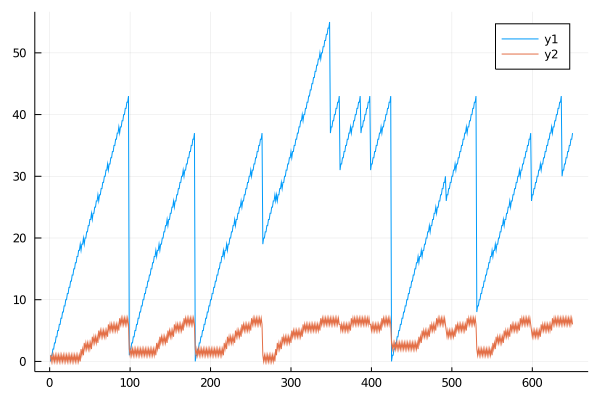

In [25]:
using Plots
plot(dropdims(sum(nodes .== 0.0, dims=1), dims=1))
plot!(dropdims(sum(nodes .== 1.0, dims=1), dims=1))

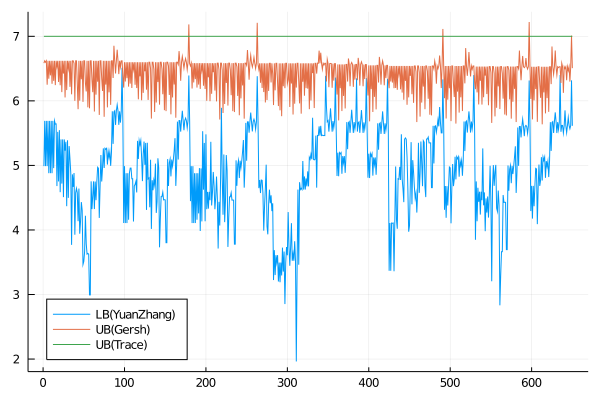

In [26]:
plot(boundsData', label=["LB(YuanZhang)" "UB(Gersh)" "UB(Trace)"], legend=:bottomleft)

In [31]:
(sum(sum(nodes .== 1.0, dims=1) .>= reshape(Array(1:7), (7, 1)), dims=2)) ./ Float64(size(nodes, 2))

7×1 Array{Float64,2}:
 0.9584615384615385
 0.8430769230769231
 0.7215384615384616
 0.6323076923076923
 0.5261538461538462
 0.3569230769230769
 0.12615384615384614